# Join data for Shots

* Group json files by repetitions
* Extract error and runs data
* Average this data
* Save in a new json file

In [38]:
from os import walk
import json
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

from sklearn.metrics import mean_squared_error


optimizers = ["gradient_descent", "spsa", "adam"]
train_types= [ 'vqe_previous','meta', 'opt_meta']

with open('./h2_fci.json', 'r') as reader:
    # Read & print the entire file
    data = reader.read()
    fci_h2 = json.loads(data)  

fci_energies = fci_h2["energies"]


f = []
for (dirpath, dirnames, filenames) in walk('./'):
    f.extend(filenames)
    break

print(len(f))

29


In [39]:
# Ordered by pairs - fd,ps
main_groups = [ "simplified2design_4layers_fd", "simplified2design_4layers_ps","meta_singles_doubles_fd", "meta_singles_doubles_ps", "meta_doubles_fd", "meta_doubles_ps","kupccgsd_1layers_fd", "kupccgsd_1layers_ps"]

In [40]:
condensed_data = []

for group_count,file_name_base in enumerate(main_groups):

    with open(f'./{file_name_base}.json', 'r') as reader:
        # Read & print the entire file
        data = reader.read()
        data_entry = json.loads(data)
    
    group_dict = {i:{"errors":[0.0 for _ in train_types], "runs":[ 0 for _ in train_types]} for i in optimizers}
    for opt in optimizers:
        for count, result_type in enumerate(train_types):
            if result_type == 'meta':
                group_dict[opt]["runs"][count] += data_entry['results'][opt][result_type]['runs']
                group_dict[opt]["errors"][count] += mean_squared_error(fci_energies, data_entry['results'][opt][result_type]["energies_after_meta"], squared=False)*1000

            else:
                group_dict[opt]["runs"][count] += np.sum(data_entry['results'][opt][result_type]['runs_per_step'])
                group_dict[opt]["errors"][count] += mean_squared_error(fci_energies, [energy[-1] for energy in data_entry['results'][opt][result_type]["energies"]], squared=False)*1000                  

    condensed_data.append(group_dict)


In [41]:
plot_data = []
for i in range(int(len(main_groups)/2)):
    for count,result_type in enumerate(train_types):
        row=[]
        for opt in optimizers:
            row.append(condensed_data[2*i][opt]["errors"][count])
            row.append(condensed_data[2*i+1][opt]["errors"][count])
        plot_data.append(row)


In [42]:
import pandas as pd


arrays = []
for i in range(int(len(main_groups)/2)):
    for result_type in train_types:
        arrays.append((main_groups[2*i][0:-3].replace('_', '-'), result_type.replace('_', '-')))

In [43]:
arrays

[('simplified2design-4layers', 'vqe-previous'),
 ('simplified2design-4layers', 'meta'),
 ('simplified2design-4layers', 'opt-meta'),
 ('meta-singles-doubles', 'vqe-previous'),
 ('meta-singles-doubles', 'meta'),
 ('meta-singles-doubles', 'opt-meta'),
 ('meta-doubles', 'vqe-previous'),
 ('meta-doubles', 'meta'),
 ('meta-doubles', 'opt-meta'),
 ('kupccgsd-1layers', 'vqe-previous'),
 ('kupccgsd-1layers', 'meta'),
 ('kupccgsd-1layers', 'opt-meta')]

In [44]:
columns = [('Gradient','fd'),('Gradient','ps'),('SPSA','fd'),('SPSA','ps'),('ADAM','fd'),('ADAM','ps')]

In [45]:
df = pd.DataFrame(plot_data, index=arrays, columns = columns)
df.columns = pd.MultiIndex.from_tuples(df.columns)
df.index = pd.MultiIndex.from_tuples(df.index)
pd.options.display.float_format = '{:.3f}'.format
df

Gradient            SPSA           
                                             fd      ps      fd      ps   
simplified2design-4layers vqe-previous    2.668   2.668 229.307 229.307  \
                          meta          254.312 254.311 626.152 626.152   
                          opt-meta       34.785  34.785  52.414  52.414   
meta-singles-doubles      vqe-previous    0.123   0.123   1.574   1.576   
                          meta           29.925  29.925 146.567 146.567   
                          opt-meta        0.163   0.163   2.120   2.116   
meta-doubles              vqe-previous    0.122   0.122   0.734   0.734   
                          meta           67.518  67.518 117.082 117.082   
                          opt-meta        0.113   0.113   0.928   0.928   
kupccgsd-1layers          vqe-previous    0.056   0.056  33.185  77.224   
                          meta           19.840  19.840  68.734  68.734   
                          opt-meta        0.055   0.055   1.519   3.439   

                                         ADAM         
                                           fd     ps  
simplified2design-4layers vqe-previous  3.683  3.683  
                          meta         58.264 58.264  
                          opt-meta     19.477 19.477  
meta-singles-doubles      vqe-previous  0.036  0.036  
                          meta          5.015  5.015  
                          opt-meta      0.171  0.171  
meta-doubles              vqe-previous  0.043  0.043  
                          meta         57.753 57.753  
                          opt-meta      0.080  0.080  
kupccgsd-1layers          vqe-previous  0.701  0.104  
                          meta          7.076  7.076  
                          opt-meta      0.144  0.546

In [46]:
print(df.to_latex(float_format="{:.3f}".format))

\begin{tabular}{llrrrrrr}
\toprule
 &  & \multicolumn{2}{r}{Gradient} & \multicolumn{2}{r}{SPSA} & \multicolumn{2}{r}{ADAM} \\
 &  & fd & ps & fd & ps & fd & ps \\
\midrule
\multirow[t]{3}{*}{simplified2design-4layers} & vqe-previous & 2.668 & 2.668 & 229.307 & 229.307 & 3.683 & 3.683 \\
 & meta & 254.312 & 254.311 & 626.152 & 626.152 & 58.264 & 58.264 \\
 & opt-meta & 34.785 & 34.785 & 52.414 & 52.414 & 19.477 & 19.477 \\
\cline{1-8}
\multirow[t]{3}{*}{meta-singles-doubles} & vqe-previous & 0.123 & 0.123 & 1.574 & 1.576 & 0.036 & 0.036 \\
 & meta & 29.925 & 29.925 & 146.567 & 146.567 & 5.015 & 5.015 \\
 & opt-meta & 0.163 & 0.163 & 2.120 & 2.116 & 0.171 & 0.171 \\
\cline{1-8}
\multirow[t]{3}{*}{meta-doubles} & vqe-previous & 0.122 & 0.122 & 0.734 & 0.734 & 0.043 & 0.043 \\
 & meta & 67.518 & 67.518 & 117.082 & 117.082 & 57.753 & 57.753 \\
 & opt-meta & 0.113 & 0.113 & 0.928 & 0.928 & 0.080 & 0.080 \\
\cline{1-8}
\multirow[t]{3}{*}{kupccgsd-1layers} & vqe-previous & 0.056 & 0.056 & 33.

In [47]:
## Simplified: (WIRES + LAYERS*(WIRES-1)*2)
## Single Double Excitations: 1 per excitation
## kupccgsd: 6*LAYERS

## For fd: (Nvars*4)+1
overheads_fd = [22,28,3,1,6]

## For ps - simplified: (Nvars*2)
## For ps - excitations, kupccgsd: (Nvars*4)
overheads_ps = [44,56,12,4,24]

index_per_runs_plot_fd = [0,2,4,6,8]
index_per_runs_plot_ps = [1,3,5,7,9]

# overheads_fd = [13,5,25]
# overheads_ps = [48,16,96]




# index_per_runs_plot_fd = [0,2,4]
# index_per_runs_plot_ps = [1,3,5]

IndexError: list index out of range

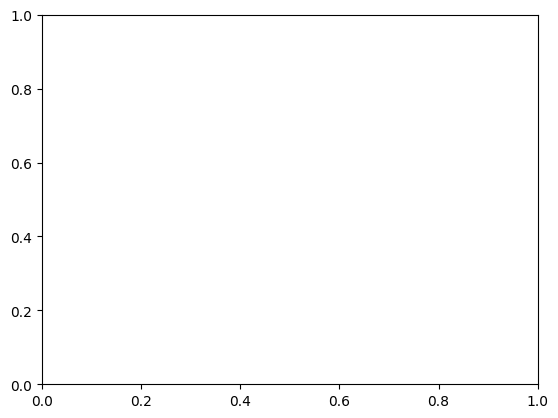

In [48]:
opt_runs = optimizers[1]

fig, ax = plt.subplots()

vqe_ran_data = [condensed_data[idx][opt_runs]["runs"][0]*(overheads_fd[count]+1) for count,idx in enumerate(index_per_runs_plot_fd)]
vqe_prev_data = [condensed_data[idx][opt_runs]["runs"][1]*(overheads_fd[count]+1) for count,idx in enumerate(index_per_runs_plot_fd)]
meta_runs = [condensed_data[idx][opt_runs]["runs"][2]*(overheads_fd[count]+1)*5*4 for count,idx in enumerate(index_per_runs_plot_fd)]
opt_meta_data = [condensed_data[idx][opt_runs]["runs"][3]*(overheads_fd[count]+1) for count,idx in enumerate(index_per_runs_plot_fd)]

vqe_ran_data_ps = [condensed_data[idx][opt_runs]["runs"][0]*overheads_ps[count] for count,idx in enumerate(index_per_runs_plot_ps)]
vqe_prev_data_ps = [condensed_data[idx][opt_runs]["runs"][1]*overheads_ps[count] for count,idx in enumerate(index_per_runs_plot_ps)]
meta_runs_ps = [condensed_data[idx][opt_runs]["runs"][2]*overheads_ps[count]*5*4 for count,idx in enumerate(index_per_runs_plot_ps)]
opt_meta_data_ps = [condensed_data[idx][opt_runs]["runs"][3]*overheads_ps[count] for count,idx in enumerate(index_per_runs_plot_ps)]



ind = np.arange(len(vqe_ran_data)) 

width = 0.12                    # the width of the bars

ax.set_ylabel('Number of Runs')
ax.set_title(f'Total Runs per Ansatz {opt_runs}')
xTickMarks = [main_groups[idx] for idx in index_per_runs_plot_fd]
ax.set_xticks(ind+(3*width))
xtickNames = ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames, rotation=45, fontsize=10)


plt.bar(np.arange(len(vqe_ran_data)), vqe_ran_data, width=width, label = "vqe ran")
plt.bar(np.arange(len(vqe_prev_data))+ width, vqe_prev_data, width=width, label = "vqe prev")
plt.bar(np.arange(len(meta_runs))+ width*2, meta_runs, width=width, label="meta")
plt.bar(np.arange(len(opt_meta_data))+ width*2, opt_meta_data, width=width, bottom= meta_runs, label="opt-meta")

plt.bar(np.arange(len(vqe_ran_data_ps))+ width*4, vqe_ran_data_ps, width=width, label="vqe ran ps")
plt.bar(np.arange(len(vqe_prev_data_ps))+ width*5, vqe_prev_data_ps, width=width, label = "vqe prev ps")
plt.bar(np.arange(len(meta_runs_ps))+ width*6, meta_runs_ps, width=width, label="meta ps")
plt.bar(np.arange(len(opt_meta_data_ps))+ width*6, opt_meta_data_ps, width=width, bottom= meta_runs_ps, label="opt-meta ps")
ax.legend()
plt.yscale('log')
plt.ylim(100, 500000)
plt.show()

[39050, 56000, 4650, 935, 7290]


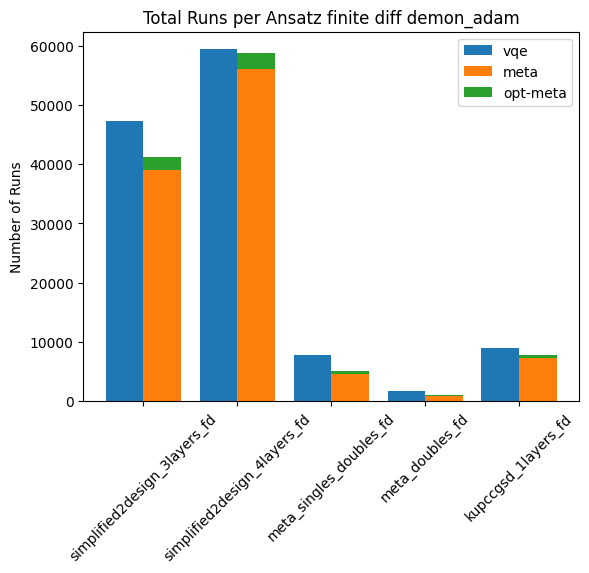

In [ ]:
opt_runs = optimizers[3]

fig, ax = plt.subplots()

vqe_data = [condensed_data[idx][opt_runs]["runs"][0]*overheads_fd[count] for count,idx in enumerate(index_per_runs_plot_ps)]
meta_runs = [condensed_data[idx][opt_runs]["runs"][1]*overheads_fd[count]*5 for count,idx in enumerate(index_per_runs_plot_ps)]
opt_meta_data = [condensed_data[idx][opt_runs]["runs"][2]*overheads_fd[count] for count,idx in enumerate(index_per_runs_plot_ps)]


print(meta_runs)


ind = np.arange(len(vqe_data)) 

width = 0.4                      # the width of the bars

ax.set_ylabel('Number of Runs')
ax.set_title(f'Total Runs per Ansatz finite diff {opt_runs}')
xTickMarks = [main_groups[idx] for idx in index_per_runs_plot_fd]
ax.set_xticks(ind+(width/2))
xtickNames = ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames, rotation=45, fontsize=10)


plt.bar(np.arange(len(vqe_data)), vqe_data, width=width, label = "vqe")
plt.bar(np.arange(len(meta_runs))+ width, meta_runs, width=width, label="meta")
plt.bar(np.arange(len(opt_meta_data))+ width, opt_meta_data, width=width, bottom= meta_runs, label="opt-meta")
ax.legend()
plt.show()